# Simulación de los modelos XY, Villain e Ising
El objetivo de este código es simular los modelos mencionados usando los siguientes algoritmos
- Metropolis-Hasting para XY
- Swendsen-Wang para Villain
- IvG usando "accepting-rejection"
- Gas de Coulumb

# Librerias a usar
a continuación usaremos las siguientes librerias:
- numpy
- math
- matplotlib.pyplot
- scipy
- colour
- seaborn

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import colour as cl
print("importaciones listas")

importaciones listas


# Algoritmo Metropolis-Hasting
A continuación se implementará algunas variaciones del algoritmo Metropolis-Hasting (desde ahora M.H.) para simular el modelo XY.

Primero veamos algunas funciones auxiliares que necesitaremos.

In [2]:
#n: radio del reticulado entera

def todos_ordenados(n):
    l = 2*n+1
    x = np.zeros((l, l, 2))
    for i in range(l):
        for j in range(l):
            x[i,j, 0] = 1
    return x

def rotacion(u):
    a = np.cos(u)
    b = np.sin(u)

    R = np.array([[a, -b],[b, a]])
    return R

def promV(x, i ,j, n):
    l = 2*n
    v_x = [x[i,j+1*(j<l), :]*(j<l), x[i,j-1*(j>0), :]*(j>0), x[i+1*(i<l),j, :]*(i<l), x[i-1*(i>0),j, :]*(i>0)]
    d_x = 1*(j<l) + 1*(0<j) + 1*(0<i) + 1*(i<l)
    return (1/d_x)*sum(v_x)

def resta(x,y, i, j, n):
    l=2*n
    v_x = [x[i,j+1*(j<l), :], x[i,j-1*(j>0), :], x[i+1*(i<l),j, :], x[i-1*(i>0),j, :]]
    vx = 0
    v_y = [y[i,j+1*(j<l), :], y[i,j-1*(j>0), :], y[i+1*(i<l),j, :], y[i-1*(i>0),j, :]]
    vy=0
    for vecinoY in v_y:
        vy+=np.linalg.norm(y[i,j,:] - vecinoY)**2
    for vecinoX in v_x:
        vx+=np.linalg.norm(x[i, j,:] - vecinoX)**2
    return vy-vx

def gibbs_XY(x, y, i, j,n, beta):
    return np.exp( (-beta/2)*resta(x, y, i,j ,n) )

def q(x, y, i ,j, n, beta):
    l = 2*n
    v_x = [x[i,j+1*(j<l), :]*(j<l), x[i,j-1*(j>0), :]*(j>0), x[i+1*(i<l),j, :]*(i<l), x[i-1*(i>0),j, :]*(i>0)]
    d_x = 1*(j<l) + 1*(0<j) + 1*(i<l) + 1*(0<i)
    c_x = (1/d_x)*sum(v_x)
    r_x =np.linalg.norm(c_x)
    vec = y[i, j,:]
    x = vec[0]
    y = vec[1]
    theta = 2*np.arctan((y/x))
    return np.exp((-1)*d_x*beta*((theta/r_x)**2))

def q_2(x, y, i, j, n, beta):
    l = 2*n
    v_x = [x[i,j+1*(j<l), :]*(j<l), x[i,j-1*(j>0), :]*(j>0), x[i+1*(i<l),j, :]*(i<l), x[i-1*(i>0),j, :]*(i>0)]
    d_x = 1*(j<l) + 1*(0<j) + 1*(i<l) + 1*(0<i)
    c = (1/d_x)*sum(v_x)
    return np.exp(d_x*beta*0.5*(np.linalg.norm(y[i, j,:] - c)**2))

## Variación 1
Aquí veremos que pasa si el valor a postular es un vector gaussiano 2d normalizado

In [3]:
def postula(x, n, beta):
    y = np.copy(x)
    l =2*n+1
    i = np.random.randint(0, l)
    j = np.random.randint(0, l)
    c = promV(x, i, j,n)
    r = np.linalg.norm(c)
    c_1 = (r**(-1))*c
    theta = 100
    sigma =np.sqrt((1/(r*beta)))
    while (theta>np.pi) or (theta< -1*np.pi):
        theta = np.random.normal(loc = 0, scale = sigma)
    y[i, j,:] = rotacion(theta)@c_1
    return (i, j, y)

def Metropolis_Hasting_XY(N, n, x_0, beta):
    x = x_0
    U = np.random.uniform(size=N)
    for k in range(N):
        u = U[k]
        i, j , y = postula(x, n, beta)
        c = gibbs_XY(x, y, i, j,n, beta)
        Q = q(x,y, i, j, n,beta)/q(y, x, i, j, n,beta)
        alpha = c*Q
        if alpha >= u:
            x = y
        else:
            x = x
    return x

## Variación 2
Aquí veremos que pasa si el valor a postular es la idea de Avelio dada

In [4]:
def postula_2(x, n, beta):
    y = np.copy(x)
    l =2*n+1
    ll=l-1
    i = np.random.randint(0, l)
    j = np.random.randint(0, l)
    c = promV(x, i, j,n)
    d_x = 1*(j<ll) + 1*(0<j) + 1*(0<i) + 1*(i<ll)
    sigma = (1/(d_x*beta))
    cx = c[0]
    cy = c[1]
    postulo_x = np.random.normal(loc=cx, scale=sigma)
    postulo_y = np.random.normal(loc=cy, scale=sigma)
    r = np.linalg.norm(np.array([postulo_x, postulo_y]))
    y[i, j, 0] = (r**(-1))*postulo_x
    y[i, j, 1] = (r**(-1))*postulo_y
    return (i, j, y)

def Metropolis_Hasting2_XY(N, n, x_0, beta):
    x = x_0
    U = np.random.uniform(size=N)
    for k in range(N):
        u = U[k]
        i, j , y = postula_2(x, n, beta)
        c = gibbs_XY(x, y, i, j,n, beta)
        Q = q_2(x,y, i, j, n,beta)/q_2(y, x, i, j, n,beta)
        alpha = c*Q
        if alpha >= u:
            x = y
        else:
            x = x
    return x

# Visualización

A continuación veremos una función que nos permite graficar los valores obtenidos al considerar la representación de color HSV, en particular, fijaremos s = 1, v = 0.5, y el valor H (hue) será el ángulo del valor correspondiente al vertice


In [5]:
def color_hue(vector_color):
    x = vector_color[0]
    y = vector_color[1]
    return np.arctan((y/x))

def color_hue_2(vector_color):
    x = vector_color[0]
    y = vector_color[1]
    return 2*np.arctan((y/x))

In [6]:
# Las siguientes líneas de código son cortesía de Catalina Lizana, muchas gracias Catalina.
def coloreando_V(XY, n, a, b, beta, modelo):
    l = 2*n+1
    plt.figure(figsize=(a,b))
    for i in range(l):
        for j in range(l):
            color_vector = XY[i, j,:]
            color = cl.Color(hue=color_hue_2(color_vector), saturation=1, luminance=0.3)
            plt.plot(i,j, marker="o", color=str(color))
    plt.title("Visualización de " + modelo +" a beta igual " +str(beta))
    plt.show()


In [7]:
def coloreando(XY, n, a, b, beta, modelo):
    l = 2*n+1
    plt.figure(figsize=(a,b))
    for i in range(l):
        for j in range(l):
            colorH = XY[i, j]
            color = cl.Color(hue=colorH, saturation=1, luminance=0.3)
            plt.plot(i,j, marker="o", color=str(color))
    plt.title("Visualización de " + modelo +" a beta igual " +str(beta))
    plt.show()

In [8]:
def viendo_el_grafo(M_v, M_h, n,a,b):
    #M_v es de lxl+1 y M_h es de l+1x1
    l =2*n+1
    plt.figure(figsize=(a,b))
    for fila in range(l):
        for columna in range(l):
            #horizontales
            if columna<(l-1):
                if M_h[fila,columna] == 1:
                    y = (fila, fila)
                    x = (columna, columna+1)
                    plt.plot(x,y, marker = "o", color = "black")
            #verticales
            if fila<(l-1):
                if M_v[fila,columna] == 1:
                    y = (fila, fila+1)
                    x = (columna, columna)
                    plt.plot(x,y, marker = "o", color = "black")
            #else:
              #  plt.plot(fila,columna, marker ="o", color= "black")
            plt.plot(fila,columna, marker ="o", color= "black")
    plt.title("Rejilla a aristas abiertas y cerradas dadas")
    plt.show()

In [9]:
def clusters_grafo(M_v, M_h, n,a,b, XY):
    l =2*n+1
    fig, ax = plt.subplots(1,2, figsize = (a,b))
    for fila in range(l):
        for columna in range(l):
            #horizontales
            if columna<(l-1):
                if M_h[fila,columna] == 1:
                    y = (fila, fila)
                    x = (columna, columna+1)
                    ax[0].plot(x,y, marker = "o", color = "black")
            #verticales
            if fila<(l-1):
                if M_v[fila,columna] == 1:
                    y = (fila, fila+1)
                    x = (columna, columna)
                    ax[0].plot(x,y, marker = "o", color = "black")
            ax[0].plot(fila,columna, marker ="o", color= "black")

    for i in range(l):
        for j in range(l):
            #color_H = XY[i, j]
            color = cl.Color(hue= XY[i,j], saturation=1, luminance=0.5)
            ax[1].plot(i,j, marker="o", color=str(color))
    plt.title("grafo despues de clusterización y observación v.a.")
    plt.show()

# ¿Que estoy haciendo?
Para entender un poco que estoy haciendo visualizaremos lo que estamos obteniendo usaremos la función anterior para graficar algunos resultados, la idea es comparar los métodos
- Metropolis_Hasting
- Metropolis_Hasting2
- Metropolis_Hasting3

todos los métodos se probarán con un valor inicial de "todos a la derecha", para esto primero, pondremos unos valores razonables para probar

# Resultados

A continuación veremos que da con la transición “propuesta_2”

In [15]:
n_1 = 150
N_1 = (2*n_1+1)**3
x_1 = todos_ordenados(n_1)
#beta = (0.07)**(-1)
a=8
b=6


In [ ]:
%%time
XY_12 = Metropolis_Hasting2_XY(N_1, n_1, x_1, 10) #1/np.sqrt(2*np.pi))
XY_22 = Metropolis_Hasting2_XY(N_1, n_1, x_1, 1)

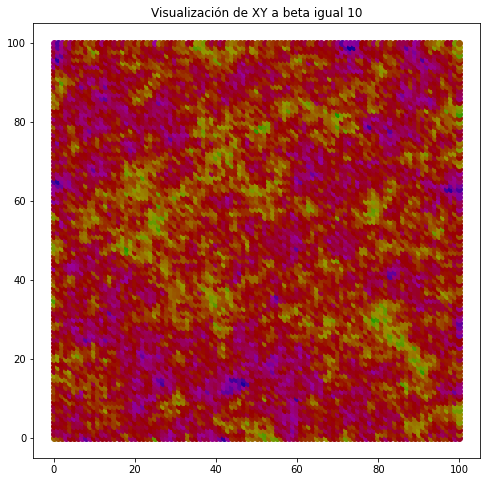

In [13]:
coloreando_V(XY_12,n_1,8,8, 10, "XY")

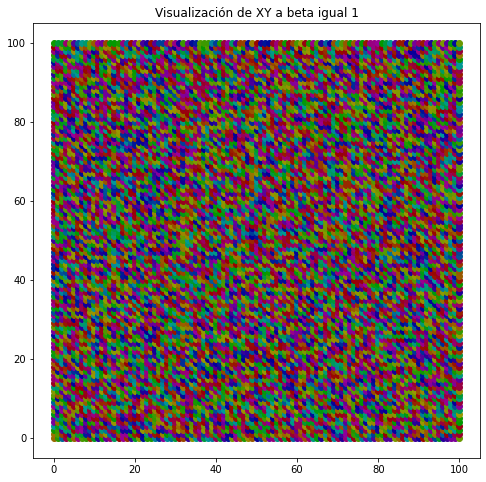

In [14]:
coloreando_V(XY_22,n_1,8,8, 1, "XY")

# Algoritmo Swendsen-Wang
A continuación se implementará el código de Swedsen-wang (desde ahora S.W.) para el modelo XY para después comparar con los resultados de M.H.

Primero, puesto que tengo el pseudo-código a mano gracias al paper del profe, veremos como hacer S.W. en el modelo de Villain
La bibliografía se dara más adelante.

Después todo lo realizado se pasara a clase, preguntar a Gustavo.


## S.W. en Villain
Como ejemplo de juguete primero veamos el algoritmo S.W. para el modelo de Ising, pues es el más simple de implementar. Aquí los objetivos es ver
- como usar y mover la variable $d = (d_x)_{x\in E}$
- como relacionar lo anterior con las leyes marginales correspondientes
- que objeto usar para tratar con la variable aleatoria y la variable $d$

### Densidades a usar
Primero veamos las funciones que nos exige el algoritmo usar para ir declarando abierto o cerrado.

In [10]:
def Serie_LHS(x, t):
    S1 = np.array([-2,-1,0,1,2])
    return np.sqrt(t)*sum([np.exp(-1*t*np.pi*((x+n)**2)) for n in S1])

def Serie_RHS(x, t):
    S1 = np.array([1,2])
    return 1+2*sum([np.exp(-1*np.pi*(t**(-1))*(n**2))*np.cos(2*np.pi*n*x) for n in S1])

In [11]:
def f(x, beta):
    Tau = 2*np.pi*beta
    t = 1/beta
    if t<2*np.pi:
        return Serie_LHS(x/(2*np.pi), Tau)/np.sqrt(Tau)
    elif t>=2*np.pi:
        return  Serie_RHS(x/(2*np.pi),Tau)/np.sqrt(Tau)

#Tengo que reparar esto
def g(theta_1, theta_2, beta):
    x = theta_1-theta_2
    y = theta_1+theta_2-np.pi
    return (f(x,beta)-f(y,beta))/f(x, beta)

Veamos un poco su comportamiento.

In [12]:
#La idea fuerte es ver la transición de un estado a otro usando los clusters, para esto codifiquemos primero
#lo que necesitamos de los clusters y después hacemos la transición

#Re-hacer.

def cambio_eje(x,nu):
    y=np.copy(x)
    mod = 2*np.pi
    return (y + nu)%mod

def cambio_eje_b0(x,nu,n):
    l = 2*n+1
    y=np.copy(x)
    mod = 2*np.pi
    for i in range(1,l-1):
        for j in range(1,l-1):
            theta = y[i,j]
            theta_R = (theta+nu)%mod
            y[i,j] = theta_R
    return y


In [13]:

def Aristas_V(n,x_0,beta, nu):
    l=2*n

    M_v = np.zeros((l,l+1))
    mod = 2*np.pi
    for fila in range(l):
        for columna in range(l+1):
            u = np.random.uniform(low=0, high=1)
            theta_1= x_0[fila, columna]
            theta_2= x_0[fila+1, columna]
            angle_1 = (theta_1-nu)%mod
            angle_2 = (theta_2-nu)%mod
            if (np.cos(angle_1)>0) and (np.cos(angle_2)>0): # recuerda en el paper es -nu
                #test == np.random.binomial(1, g(angle_1,angle_2, beta))
                if u<=g(angle_1,angle_2, beta):
                    M_v[fila, columna] = 1 #np.random.binomial(1, g(angle_1,angle_2, beta)) #open
            if (np.cos(angle_1)<0) and (np.cos(angle_2)<0):
                angle_1N = (np.pi + angle_1)%mod
                angle_2N = (np.pi + angle_2)%mod
                if u<=g(angle_1N,angle_2N, beta):
                    M_v[fila, columna] = 1 #np.random.binomial(1, g(angle_1N,angle_2N, beta)) #open
    return M_v


def Aristas_H(n,x_0,beta,nu):
    l=2*n
    M_h = np.zeros((l+1,l))
    mod = 2*np.pi
    for fila in range(l+1):
        for columna in range(l):
            u2 = np.random.uniform(low=0, high=1)
            theta_1= x_0[fila, columna]
            theta_2= x_0[fila, columna+1]   # recuerda en el paper es -nu
            angle_1 = (theta_1-nu)%mod
            angle_2 = (theta_2-nu)%mod
            if (np.cos(angle_1)>0) and (np.cos(angle_2)>0):
                if u2<=g(angle_1,angle_2, beta):
                    M_h[fila, columna] = 1 #np.random.binomial(1, g(angle_1,angle_2, beta)) #open
            if (np.cos(angle_1)<0) and (np.cos(angle_2)<0):
                angle_1N = (np.pi+angle_1)%mod
                angle_2N = (np.pi+angle_2)%mod
                if u2<=g(angle_1N, angle_2N, beta):
                    M_h[fila, columna] = 1 # np.random.binomial(1, g(angle_1N, angle_2N, beta)) #open
    return M_h

Lo anterior nos da $d$ dividido segun la arista sea vertical u horizontal

## ¿Se puede hacer más rapido?

El algoritmo de abajo salio casi en su totalidad de  $$ chrome-extension://oemmndcbldboiebfnladdacbdfmadadm/https://math.hws.edu/eck/cs327_s04/chapter9.pdf$$

In [14]:
def vecinos(fila, columna, n, M_v, M_h):
    l =2*n+1 #notice that  l^2 = |V|
    vecinos = []
    #columns
    if 0<columna<(l-1):                     #neighbors left or right
        if M_h[fila, columna] == 1:         #neighbor to the right
            vecinos.append((fila, columna+1))
        if M_h[fila, columna-1] == 1:     #neighbor to the left
            vecinos.append((fila, columna-1))
    elif columna == l-1:                    # neighbor only to the left
        if M_h[fila, columna-1] == 1:
            vecinos.append((fila, columna-1))
    elif columna == 0:                      #neighbr only to the right
        if M_h[fila, columna]== 1:
            vecinos.append((fila,columna+1))

    #rows
    if 0<fila<(l-1):                        #neighbors up or down
        if M_v[fila, columna] == 1:         #neighbor up
            vecinos.append((fila+1, columna))
        if M_v[fila-1, columna] == 1:     #neighbor down
            vecinos.append((fila-1, columna))
    elif fila == l-1:
        if M_v[fila-1, columna] == 1:       #neighbot only down
            vecinos.append((fila-1, columna))
    elif fila == 0:
        if M_v[fila, columna] ==1:           #neighbor only up
            vecinos.append((fila+1, columna))
    return vecinos

def connected_components(n, M_v,M_h):
    l = 2*n+1
    Visited = np.zeros((l,l)) #zero means the vertex (i,j) hasn't been visited
    Cc = []
    for fila in range(l):
        for columna in range(l):
            if Visited[fila,columna] == 0: #vertex not visited.
                cc = [(fila,columna)]
                Visited[fila,columna] = 1 #mark as visited
                q = [(fila,columna)]
                while q!=[]:
                    w = q[0]
                    q.remove(w)
                    chequeo = vecinos(w[0], w[1], n, M_v, M_h)
                    for k in chequeo:
                        if Visited[k] == 0:
                            q.append(k)
                            cc.append(k)
                            Visited[k] = 1
                Cc.append(cc)
    return Cc


In [15]:
# esta función me dice como roto el cluster deseado.
def Rotar(M_v,M_h, n, x, nu):
    mod = 2*np.pi
    Cc = connected_components(n, M_v,M_h)
    for cc in Cc:
        a = np.random.binomial(1, 0.5) # a number in {0,1}
        if a == 1:
            for v in cc:
                x[v] = x[v]
        else:
            for v in cc:
                x[v] = (2*nu + np.pi - x[v])%mod
    return x


# S.W. en Villain con condición de borde libre
Ahora tenemos los elementos necesarios para poder hacer S.W. en Villain (y con un pequeño cambio tambien Ising

In [16]:
def Swendsen_Wang_Villain(N, radius,beta, x0 =str(1)):
    l = 2*radius+1
    if x0 == str(1):
        x0 = np.zeros((l,l))
    else:
        x0 = x0
    x = np.copy(x0)
    #CC = []
    while N!=0:
        nu = np.random.uniform(low=0, high=2*np.pi)
        Mh_S = Aristas_H(radius,x,beta,nu)
        Mv_S = Aristas_V(radius,x,beta,nu)
        #y = np.copy(x)
        comp_connect = connected_components(radius,Mv_S,Mh_S)
        if len(comp_connect) != 1:
            x = Rotar(Mv_S, Mh_S, radius, x,nu)
        #CC.append((Mh_S, Mv_S, y, x, nu))
        N = N-1
    return x #, CC)

## Valores de prueba
A continuación empezaremos a obtener valores para ver que esta saliendo :)

In [17]:
n_T1 = 150
N_T1 = 2*(n_T1+1)
#beta = 1/np.sqrt(2*np.pi)
beta_T1L = 0.02
beta_T1H = 10
beta_T1A = 1/(np.sqrt(2*np.pi))
#beta=1000
#beta = (0.8816)**(-1)2
print("Simularemos a betas iguales ", beta_T1H,",", beta_T1L,"y", beta_T1A, "y numero de iteraciones N_0 =", N_T1)

Simularemos a betas iguales  10 , 0.02 y 0.3989422804014327 y numero de iteraciones N_0 = 302


In [123]:
%%time
Test= Swendsen_Wang_Villain(N_T1,n_T1,beta_T1A)
test_S = Test
Test2 = Swendsen_Wang_Villain(N_T1,n_T1,beta_T1H)
test2_S = Test2

CPU times: user 49min 31s, sys: 21.9 s, total: 49min 53s
Wall time: 49min 59s


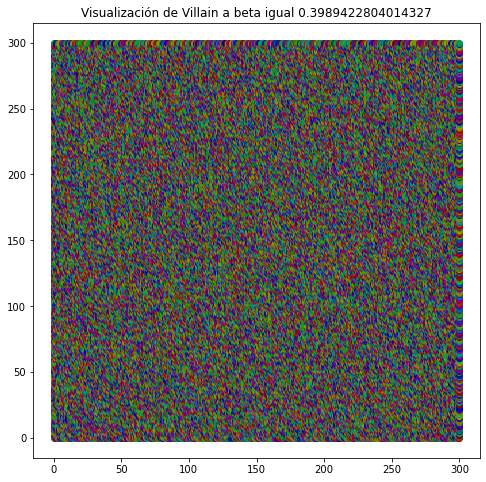

In [125]:
coloreando(test_S,n_T1,8,8, beta_T1A, "Villain")

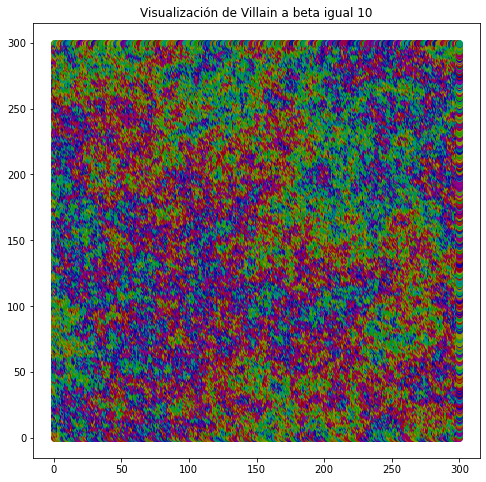

In [126]:
coloreando(test2_S,n_T1,8,8, beta_T1H, "Villain")

# S.W. con condición de borde nula
A las funciones anteriores les haremos unas pequeñas modificaciones para adaptarlas al caso de condición de borde

In [127]:
def is_in_boundary(cc,n):
    l = 2*n
    for v in cc:
        if v[0] == 0 or v[0] == l or v[1] == 0 or v[1] == l:
            return 1 # 1 will mean i am in the boundary
    else:
        return 0 # 0 means the vertex don't touch the boundary


def Rotar_BC(M_v, M_h, n, x_0, nu):
    x = np.copy(x_0)
    mod = 2*np.pi
    CC = connected_components(n, M_v, M_h)
    for cc in CC:
        if is_in_boundary(cc,n) == 0:
            a = np.random.binomial(1, 0.5) # a number in {0,1}
            if a == 1:
                for v in cc:
                    x[v] = x[v]
            else:
                for v in cc:
                    x[v] = (2*nu + np.pi - x[v])%mod
    return x

In [19]:
def Swendsen_Wang_Villain_b0(N,n,beta, x_0 = str(1)):
    #l =2*n+1
    l = 2*n+1
    if x_0 == str(1):
        x_0 = np.zeros((l,l))
    x = np.copy(x_0)
    #Cc= []
    while N!=0:
        nu = np.random.uniform(low=0, high=2*np.pi)
        M_h = Aristas_H(n,x,beta,nu)
        M_v = Aristas_V(n,x,beta,nu)
        x = Rotar_BC(M_v, M_h, n, x, nu)
        N = N-1
    return x

In [124]:
Test3= Swendsen_Wang_Villain_b0(N_T1,n_T1,beta_T1H)
test3_S = Test3

In [ ]:
coloreando(test3_S,n_T1,10,10, beta_T1H, "Villain")

# Iv.G.
La idea a continuación es simular una variable aleatoria $k$ en $\mathbb{Z}$ que tenga la siguiente densidad
$$
\mathbb{P}(k) \propto \exp(-\frac{\beta}{2}(k-\mu)^2)
$$
Para esto, lo que haremos sera utilizar el métod "accepting-rejection''

In [20]:
# Veamos la función partición

def particion(n, beta, mu):
    a = np.arange(n)
    b= a -n-1
    a = a -mu
    b = b -mu
    v1 = np.exp(((-beta)/2)*(a**2))
    v2 = np.exp(((-beta)/2)*(b**2))
    return np.sum(v1) + np.sum(v2)

In [21]:
#Funciones auxiliares a usar
#caso mu = 0

def x_a(p):
    sigma = np.random.binomial(1, 0.5)
    G = np.random.geometric(p)
    if sigma == 0:
        return G
    else:
        return -1*(G-1)

def g_aux(k, p):
    if k>=1:
        return (p/2)*((1-p)**(k-1))
    elif k<=0:
        r = np.abs(k)
        return (p/2)*((1-p)**r)

def g2_aux(k, p):
    if k>0:
        return (p/2)*((1-p)**(k-1))
    elif k<=0:
        r = np.abs(k)
        return (p/2)*((1-p)**r)

def g_2(k, p,beta):
    return (np.exp(((-beta)/2)*(k**2))/(g_aux(k,p)*2))*p

def p_o(beta):
    return 1-np.exp(-beta/2)-0.001


In [22]:
def IvG(beta):
    p = p_o(beta)
    k = x_a(p)
    u = np.random.uniform()
    while u>=g_2(k, p, beta):
        k = x_a(p)
        u = np.random.uniform()
    return k

In [40]:
# veamos ahora cuando mu !=0

#aqui la función de densidad

def g_sinC(k, p, beta, mu):
    efe = np.exp(((-beta)/2)*((k-mu)**2))
    value = g_aux(k,p)
    return efe/value

def g2_sinC(k, p, beta, mu):
    efe = np.exp(((-beta)/2)*((k-mu)**2))
    value = g2_aux(k,p)
    return efe/value

def pol(x, p, beta,mu):
     return (beta/2)*((x-mu)**2)+(np.abs(x)*np.log(1-p))

def polinomio(x,p, beta, mu):
    value = pol(x, p, beta,mu)
    return (2/p)*np.exp((-1)*value)

def cte_g(p,beta,mu):
    x_n = 0
    x_1 = (beta*mu-np.log(1-p))/beta
    x_2 = (beta*mu+np.log(1-p))/beta
    a1 = polinomio(x_2, p, beta,mu)
    a2 = polinomio(x_n, p, beta,mu)
    a3 = polinomio(x_1, p, beta,mu)
    c = max(a1,a2,a3)
    return c

def g_mu(k, p, beta, mu, c):
    efe = np.exp(((-beta)/2)*((k-mu)**2))
    value = g_aux(k,p)
    return (efe/value)*(1/c)


#aqui un valor de p razonable.



In [41]:
def IvG_mu(beta,mu):
    p = 0.3 # temporal, debemos encontrar algo mejor en [0,1) para cada \beta y \mu
    k = x_a(p)
    u = np.random.uniform()
    p_ent = np.floor(mu)
    mu_t = mu-p_ent
    c = cte_g(p, beta, mu_t)
    while u>g_mu(k, p, beta, mu_t, c):
        k = x_a(p)
        u = np.random.uniform()
    return k + p_ent

## Testeando

A continuación veremos que resulta del método implementado

In [43]:
%%time
t =100000
o7 = np.ones(t)
o8 = np.ones(t)
mu11 = np.pi
beta1 = 0.5
beta2 = 10
for l in range(t):
    o7[l] = IvG_mu(beta1,mu11)
    o8[l] = IvG_mu(beta2,mu11)

CPU times: user 6.7 s, sys: 40.5 ms, total: 6.74 s
Wall time: 6.85 s


In [35]:
min_o7 = min(o7)
max_o7 = max(o7)
dom1 = [min_o7+k  for k in range(0,int(max_o7-min_o7)+1)]
length = len(dom1)
hist = np.zeros(length)

mu = np.pi
v7 = np.zeros((length))
mu11 = mu
for k in range(length):
    v7[k] = np.exp(((-beta1)/2)*((dom1[k]-mu11)**2))
    hist[k] = np.sum(1*(o7==dom1[k]))/len(o7)

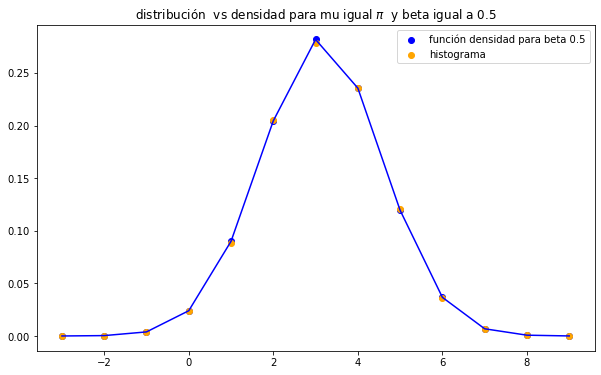

In [36]:
z1 = particion(t, beta1, mu11)

plt.figure(figsize=(10,6))
plt.scatter(dom1,v7/z1, label="función densidad para beta "+ str(beta1), color="blue")
plt.plot(dom1, v7/z1, color="blue")
plt.scatter(dom1, hist, label ="histograma", color="orange")
#plt.plot(dom1, hist, color="orange")

plt.title("distribución  vs densidad para mu igual $\pi$  y beta igual a " + str(beta1))
plt.legend()
plt.show()


In [37]:
min_o8 = min(o8)
max_o8 = max(o8)
dom2 = [min_o8+k  for k in range(0,int(max_o8-min_o8)+1)]
length = len(dom2)
hist2 = np.zeros(length)

mu = np.pi
v8 = np.zeros((length))
mu11 = mu
for k in range(length):
    v8[k] = np.exp(((-beta2)/2)*((dom2[k]-mu11)**2))
    hist2[k] = np.sum(1*(o8==dom2[k]))/len(o8)

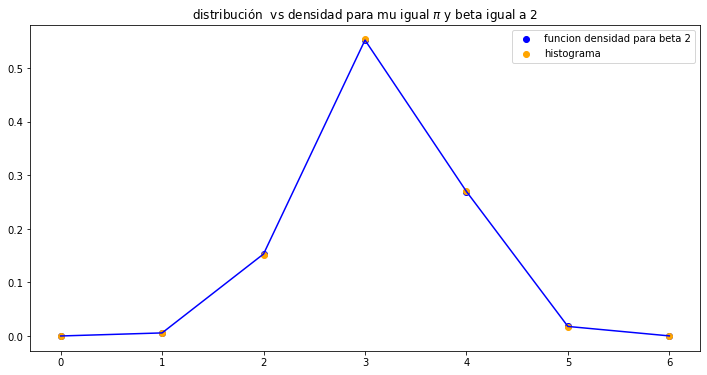

In [38]:
z2 = particion(t, beta2, mu11)

plt.figure(figsize=(12,6))
plt.scatter(dom2,v8/z2, label="funcion densidad para beta "+ str(beta2), color="blue")
plt.plot(dom2, v8/z2, color="blue")
plt.scatter(dom2, hist2, label ="histograma", color="orange")
#plt.plot(dom2, hist2, color="orange")

plt.title("distribución  vs densidad para mu igual $\pi$ y beta igual a " +str(beta2))
plt.legend()
plt.show()


In [39]:
%%time
#testeando un poco a ver que sale
t =100000
mu1 = np.pi
mu2 = 13.5
O7 = np.ones(t)
O8 = np.ones(t)
for l in range(t):
    O7[l] = IvG_mu(beta1,mu1)
    O8[l] = IvG_mu(beta1,mu2)

CPU times: user 6.93 s, sys: 74.3 ms, total: 7.01 s
Wall time: 7.29 s


In [40]:
min_O7 = min(O7)
max_O7 = max(O7)
dom3 = [min_O7+k  for k in range(0,int(max_O7-min_O7)+1)]
length = len(dom3)
hist3 = np.zeros(length)

b7 = np.zeros((length))
for k in range(length):
    b7[k] = np.exp(((-beta1)/2)*((dom3[k]-mu1)**2))
    hist3[k] = np.sum(1*(O7==dom3[k]))/len(O7)

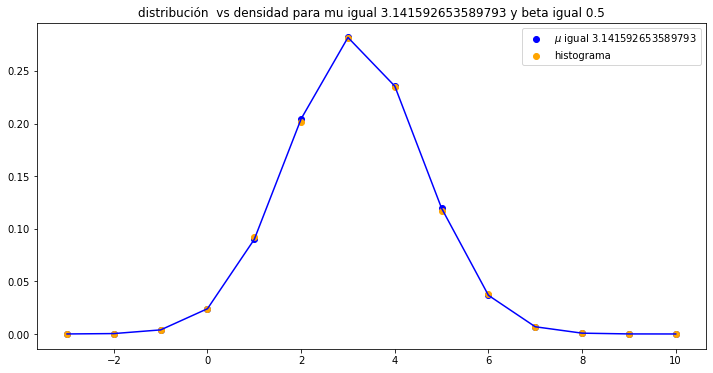

In [41]:
z11 = particion(t, beta1, mu1)

plt.figure(figsize=(12,6))
plt.scatter(dom3,b7/z11, label="$\mu$ igual "+ str(mu1),color="blue")
plt.plot(dom3, b7/z11, color="blue")
plt.scatter(dom3, hist3, label ="histograma", color="orange")
#plt.plot(dom3, hist3, color="orange")

plt.title("distribución  vs densidad para mu igual "+str(mu1)+ " y beta igual " + str(beta1))
plt.legend()
plt.show()

In [42]:
min_O8 = min(O8)
max_O8 = max(O8)
dom4 = [min_O8+k  for k in range(0,int(max_O8-min_O8)+1)]
length = len(dom4)
hist4 = np.zeros(length)

b8 = np.zeros((length))
for k in range(length):
    b8[k] = np.exp(((-beta1)/2)*((dom4[k]-mu2)**2))
    hist4[k] = np.sum(1*(O8==dom4[k]))/len(O8)

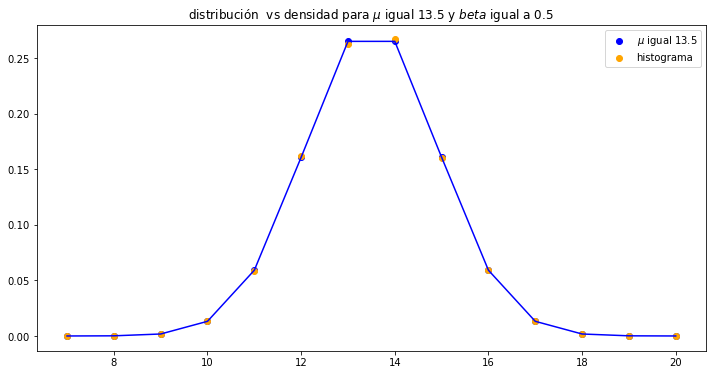

In [43]:
z22 = particion(t, beta1, mu2)

plt.figure(figsize=(12,6))
plt.scatter(dom4,b8/z22, label="$\mu$ igual "+ str(mu2),color="blue")
plt.plot(dom4, b8/z22, color="blue")
plt.scatter(dom4, hist4, label ="histograma", color="orange")
#plt.plot(dom4, hist4, color="orange")

plt.title("distribución  vs densidad para $\mu$ igual "+str(mu2)+ " y $beta$ igual a " + str(beta1))
plt.legend()
plt.show()

# P2
Avelio se dio cuenta que una perspectiva de la densidad dada para la Villain se puede ver como una distribución marginal
de un vector aleatorio $(\theta, k)$ con $\theta \in [0.2\pi]$ y $k\in \mathbb{N}^{E}$ con densidad
$$
\mathbb{P}((d\theta,k)) = \prod_{e\in E} \exp\left(\frac{-\beta}{2}(2\pi)^2(k_e - \frac{1}{2\pi}\nabla\theta_e)^2)\right)
$$

la idea es simular $k$ dado $\theta$ y guardar este resultado.

In [71]:
def Ka_v(theta, n):
    l = 2*n+1
    mu_v = np.zeros((l-1, l))
    mu_h = np.zeros((l, l-1))
    for i in range(l-1):
        mu_v[i,:] = theta[:,i] - theta[:,i+1]
        mu_h[:,i] = -theta[i,:] + theta[i+1,:]
    c = 1/(2*np.pi)
    return c*mu_v, c*mu_h

def var_k(n, theta,beta):
    l =2*n+1
    k_v = np.zeros((l-1,l))
    k_h = np.zeros((l,l-1))
    mu_s = Ka_v(theta,n)
    mu_v_0 = mu_s[0]
    mu_h_0 = mu_s[1]
    factor = (2*np.pi)**2
    for i in range(l-1):
        for j in range(l):
            a = IvG_mu(beta*factor, mu_v_0[i,j])
            b = IvG_mu(beta*factor, mu_h_0[j,i])
            k_v[i,j] = a
            k_h[j,i] = b

    return k_v, k_h



# P3
Ahora nos interesa obtener los rotores, para esto, primero crearemos la matriz "dual", i.e. la del grafo dual que se puede entender como la que se obtiene al considerar las caras como vertices y las aristas las dadas por ser caras colindantes (creo asi se dice)

In [26]:
def rotores(K_v, K_h,n):
    l = 2*n+1
    rotor = np.zeros((l-1,l-1))
    for i in range(l-1):
        for j in range(l-1):
            rotor[i,j] = ((-1)*K_v[i,j] + K_v[i,j+1] )+ (K_h[i,j] + (-1)*K_h[i+1,j])
    return rotor

## Visualizando lo deseado
La idea es visualizar lo solicitado por el profesor Avelio

In [27]:
#la idea es generealizar esto para que quede boni.
def coloreando2(rotor, n, a, b):
    l = 2*n
    plt.figure(figsize=(a,b))
    for i in range(l):
        for j in range(l):
            num = rotor[i,j]
            valor = int(num)
            if valor>0:
                plt.plot(i, j, marker ="o", color = "grey" )
            elif valor<0:
                plt.plot(i, j, marker ="o", color = "black" )

    plt.title("Visualización del rotor para beta igual a ")
    plt.show()

In [28]:
def Visualizando(Villain, rotor, n, a, b, beta):
    l = 2*n+1 #3 0 1 2
    rho = 2*l-1 # 5 0.. 4
    plt.figure(figsize=(a,b))
    for i in range(rho):
        for j in range(rho):
            if i%2 == 0 and j%2 == 0:
                l = int(i/2)
                k = int(j/2)
                color_vector = Villain[l, k]
                color = cl.Color(hue=color_vector, saturation=1, luminance=0.5)
                plt.plot(i,j, marker="o", color=str(color))
            elif i%2 !=0  and j%2 != 0:
                m = int((i-1)/2)-2
                n = int((j-1)/2)-2
                num = rotor[m,n]
                valor = int(num)
                if valor>0:
                    plt.plot(i,j, marker ="o", color = "black" )
                elif valor<0:
                    plt.plot(i,j, marker ="o", color = "gray" )
    plt.title("Valor obtenido para beta igual "+str(beta))
    plt.show()

In [88]:
#parametros a usar
n_0 = 10
N_0 = 2*n_0+1
x_0 = todos_ordenados(n_0)
#beta = 1/np.sqrt(2*np.pi)
Beta_L = 0.1
Beta_H = 10
Beta_A = 1/np.sqrt(2*np.pi)
#beta = 10
#beta=1000
#beta = (0.8816)**(-1)
l =2*n_0+1
a = 6
b = 2*a

In [115]:
%%time
theta= Swendsen_Wang_Villain(N_0,n_0, Beta_L)

CPU times: user 397 ms, sys: 6.96 ms, total: 404 ms
Wall time: 406 ms


In [116]:
%%time
auxiliar = var_k(n_0,theta, Beta_L)

CPU times: user 37.4 ms, sys: 1.49 ms, total: 38.9 ms
Wall time: 38 ms


In [117]:
k_v = auxiliar[0]
k_h = auxiliar[1]

In [118]:
%%time
rotor = rotores(k_v, k_h,n_0)

CPU times: user 345 µs, sys: 7 µs, total: 352 µs
Wall time: 354 µs


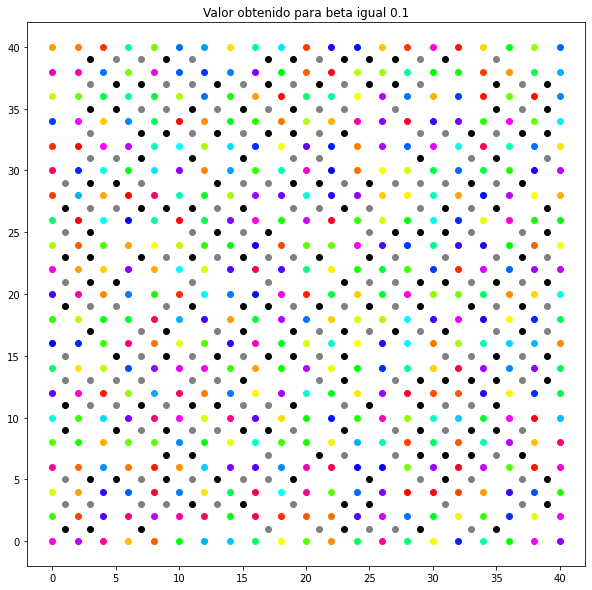

In [119]:
Visualizando(theta, rotor, n_0, 10,10, beta_L)

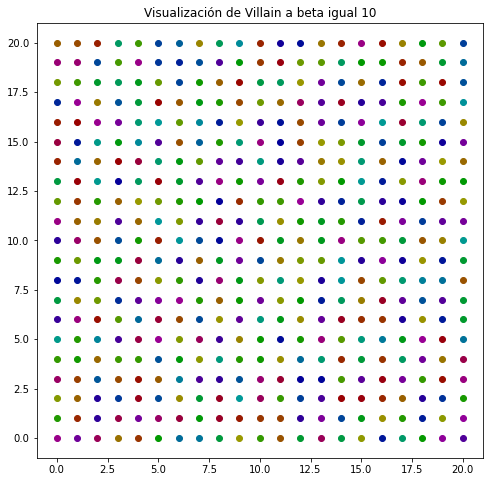

In [120]:
coloreando(theta,n_0, 8,8, beta_H,"Villain" )

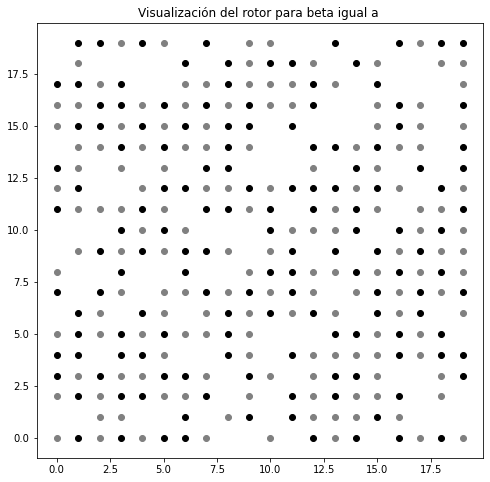

In [121]:
coloreando2(rotor, n_0,8,8)

In [122]:
np.sum(rotor)

-3.0